<a href="https://colab.research.google.com/github/onism/MyLearning/blob/master/DenoisingAE_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K 
from tensorflow.keras.datasets import mnist       
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image    
%matplotlib inline

In [2]:
np.random.seed(777)
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

# Add noise 
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise 

noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [7]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3 
latent_dim = 16
layer_filters = [32, 64]

inputs = Input(shape=input_shape)
x = inputs 

for filters in layer_filters:
    x = Conv2D(filters, kernel_size, strides=2, activation='relu', padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim)(x)
encoder = Model(inputs, latent)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [9]:

latent_inputs = Input(shape=(latent_dim,))
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape( (shape[1], shape[2], shape[3]) )(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters, kernel_size, strides=2, padding='same', activation='relu')(x)

outputs = Conv2DTranspose(1, kernel_size, padding='same', activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs)
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [10]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Model)              (None, 16)                69008     
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0364 - val_loss: 0.0205
Epoch 2/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.0194 - val_loss: 0.0183
Epoch 3/10
 817/1875 [============>.................] - ETA: 50s - loss: 0.0180

KeyboardInterrupt: ignored

In [14]:
x_decoded = autoencoder.predict(x_test_noisy)

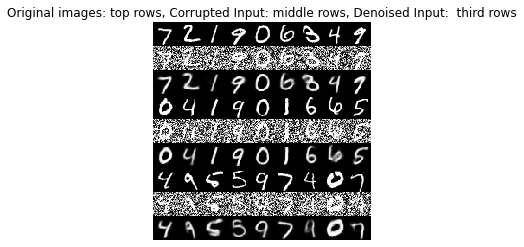

In [18]:
rows, cols = 3, 9
num = rows * cols 
imgs = np.concatenate(  [x_test[:num], x_test_noisy[:num], x_decoded[:num]]  )
imgs = imgs.reshape(( rows*3, cols, image_size, image_size))

imgs = np.vstack( np.split(imgs, rows,axis=1) )
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()